In [ ]:
### @Author : Woojin Park
### @Copyright : 2024, Unstructured Data Analysis, Korea University
### @Email : woojin_park@korea.ac.kr
### @Status : In-Progress

In [1]:
!pip install praw
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [13]:

import os
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import collections
import datetime as dt
import requests
import json
import re
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from scipy.stats import norm
from IPython.display import display, Image


import praw
import zstandard as zstd
import string
import re
import nltk
from nltk.util import ngrams
from nltk import pos_tag,word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from textblob import TextBlob



### UDF 

In [159]:
## Text Preprocessing by following pipeline : 
# 7 steps : Raw text -> lowercase ->  Remove non-alphabetic characters -> Tokeninze -> Remove stop words 
#           -> Remove Extra Punctuations -> Lemmatization -> Build Custom Stop words dictionary 

def alpha_filter(w): 
    # function which takes a word and returns true if it consists only of non-alphabetic characters
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False
    
# Build data preparation function including all the necessary 7 steps :

def clean_words(text):
    # 1. lower text & replace critical stopwords manually first
    text = text.replace('\n','')
    text = text.replace('[removed]','')
    text= text.replace('[deleted]', '')
    text= text.replace('[View Poll]','')
    text = text.lower()
    
    # 2.,3. Remove non-alphabetic characters & tokenizing 
    text = re.sub(r'[^a-zA-Z0-9 ]',r' ',text) #remove anything that is not a letter or number first
    text = [word for word in text.split(" ")]
    
    # 4. remove stop words
    nltk_stopwords = set(stopwords.words('english'))
    review_lower_stop = [x for x in text if not x in nltk_stopwords]
    
    # 5. Remove non-alphabetic characters & remove extra punctuations
    review_lower_stop_pun = [y for y in review_lower_stop if not alpha_filter(y)]
    review_lower_stop_pun_extra = \
        [''.join(x for x in par if x not in string.punctuation) for par in review_lower_stop_pun]
    
    # 6. Lemmatization
    porter = WordNetLemmatizer()
    review_lower_stop_pun_extra_lemmatized = []
    for a in review_lower_stop_pun_extra : 
        review_lower_stop_pun_extra_lemmatized.append(porter.lemmatize(a))
        
    # 7. build custom stop words dictionary
    cachedStopWords = set(stopwords.words("english"))

    # Continue updating custom stop words
    cachedStopWords.update(('www', 'https',))   
    review_lower_stop_pun_extra_lemmatized_stop = [x for x in review_lower_stop_pun_extra_lemmatized\
                                                   if not x in cachedStopWords]
    text = " ".join(review_lower_stop_pun_extra_lemmatized_stop)
    return (text)


def define_polarity(text):
    return TextBlob(text).sentiment.polarity


def categorize_group(item_name):
    if item_name in ['AnxietyDepression', 'depression']:
        return 'Depression_Group'
    elif item_name in ['technology','webdev','datascience','AskScienceDiscussion']:
        return 'Neutral_Group'
    else:
        return 'Happy_Group'
    
    


### For the classification step,
We have 3 different groups of data : Depression-related / Neutral-related / Happy-related
and each group consists of related sub-reddit groups 

Group 1 : Depression-related 
subreddit : Depression, AnxietyDepression

Group 2 : Neutral-related 
subreddit : Technology, datascience, AskScienceDiscussion, webdev

Group 3 : Happy-related
subreddit : Positivity, Happy, Mademesmile, Unexpectedlywholesome, CongratsLikeImFive


### Load Reddit archive data dump (https://the-eye.eu/redarcs/)  & Pre-processing

In [160]:
ls

MadeMeSmile_submissions.zst
Positivity_submissions.zst
UnexpectedlyWholesome_submissions.zst
anxiety_depression_submissions.parquet
anxiety_depression_submissions_preprocessed.parquet
askscience_discussion_submissions_preprocessed.parquet
congrats_submissions_preprocessed.parquet
datascience_submissions.parquet
datascience_submissions.zst
datascience_submissions_preprocessed.parquet
depression_submissions.parquet
depression_submissions.zst
depression_submissions_preprocessed.parquet
happy_submissions.parquet
happy_submissions.zst
happy_submissions_preprocessed.parquet
mademesmile_submissions.parquet
mademesmile_submissions_preprocessed.parquet
positivity_submissions.parquet
positivity_submissions_preprocessed.parquet
preprocessed_updated.zip
reddit_data_preprocessing_AnxietyDepression.ipynb
reddit_data_preprocessing_AskScienceDiscussion.ipynb
reddit_data_preprocessing_CongratsLikeImFive.ipynb
reddit_data_preprocessing_Mademesmile.ipynb
reddit_data_preprocessing_Positivity.ipynb
reddit_

In [161]:
# Group 1 : Depression-related subreddit : Depression, AnxietyDepression

anxiety_depression_submissions_preprocessed = \
    pd.read_parquet('anxiety_depression_submissions_preprocessed.parquet', engine='pyarrow')
depression_submissions_preprocessed = \
    pd.read_parquet('depression_submissions_preprocessed.parquet',engine='pyarrow')

# Group 2 : Neutral-related subreddit : Technology, datascience, AskScienceDiscussion, webdev

technology_submissions_preprocessed = \
    pd.read_parquet('technology_submissions_preprocessed.parquet', engine='pyarrow')
datascience_submissions_preprocessed = \
    pd.read_parquet('datascience_submissions_preprocessed.parquet',engine='pyarrow')
webdev_submissions_preprocessed = \
    pd.read_parquet('webdev_discussion_submissions_preprocessed.parquet',engine='pyarrow')
AskScienceDiscussion_submissions_preprocessed = \
    pd.read_parquet('askscience_discussion_submissions_preprocessed.parquet',engine='pyarrow')

# Group 3 : Happy-related subreddit : Positivity, Happy, Mademesmile, Unexpectedlywholesome, CongratsLikeImFive

positivity_submissions_preprocessed = \
    pd.read_parquet('positivity_submissions_preprocessed.parquet', engine='pyarrow')
happy_submissions_preprocessed = \
    pd.read_parquet('happy_submissions_preprocessed.parquet',engine='pyarrow')
mademesmile_submissions_preprocessed = \
    pd.read_parquet('mademesmile_submissions_preprocessed.parquet',engine='pyarrow')
unexpectedlyWholesome_submissions_preprocessed = \
    pd.read_parquet('unexpectedlyWholesome_submissions_preprocessed.parquet',engine='pyarrow')
congrats_submissions_preprocessed = \
    pd.read_parquet('congrats_submissions_preprocessed.parquet',engine='pyarrow')

In [163]:
## load lists of dataframe and concat whole subreddit data
frames = [anxiety_depression_submissions_preprocessed,\
          depression_submissions_preprocessed,\
          technology_submissions_preprocessed,\
          AskScienceDiscussion_submissions_preprocessed,\
          webdev_submissions_preprocessed,\
          datascience_submissions_preprocessed,\
          positivity_submissions_preprocessed,\
          mademesmile_submissions_preprocessed,\
          unexpectedlyWholesome_submissions_preprocessed,\
          congrats_submissions_preprocessed,\
          happy_submissions_preprocessed]
## concat
whole_df = pd.concat(frames)

In [165]:
## pre-processing steps : 
whole_df['title_with_selftext'] = whole_df['title'] + str(' ') + whole_df['selftext']
## Text Preprocessing by following pipeline : 
# 7 steps : Raw text -> lowercase ->  Remove non-alphabetic characters -> Tokeninze -> Remove stop words 
#           -> Remove Extra Punctuations -> Lemmatization -> Build Custom Stop words dictionary 
whole_df["title_with_selftext_cleaned"] = \
    whole_df["title_with_selftext"].apply(lambda x: clean_words(x))

## generate polarity score feature
whole_df['polarity'] = whole_df['title_with_selftext_cleaned'].apply(define_polarity)

## generate class group feature 
whole_df['class_group'] = whole_df['subreddit'].apply(categorize_group)


### EDA and Data re-sampling with 1.polarity score and 2.group-wise size

Depression_Group_df lenghth is  : 264629

Neutral_Group_df lenghth is  : 217976

Happy_Group_df lenghth is  : 48051



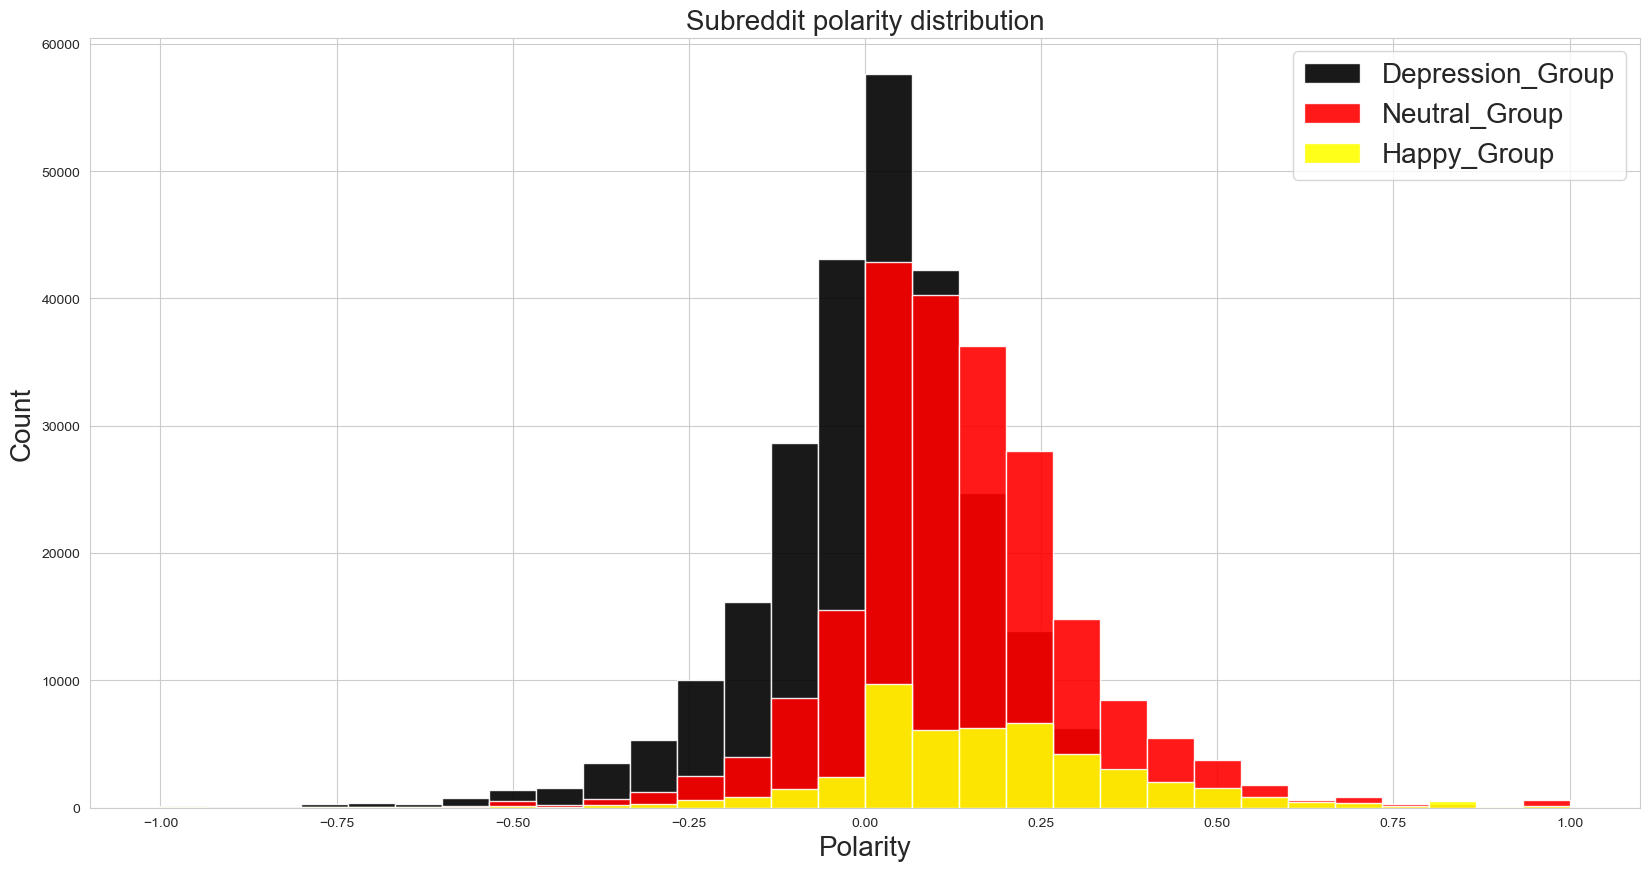

In [167]:
Depression_Group_df  = whole_df[whole_df['class_group'] == 'Depression_Group']
Neutral_Group_df  = whole_df[whole_df['class_group'] == 'Neutral_Group']
Happy_Group_df  = whole_df[whole_df['class_group'] == 'Happy_Group']

print(f'Depression_Group_df lenghth is  : {len(Depression_Group_df)}')
print()
print(f'Neutral_Group_df lenghth is  : {len(Neutral_Group_df)}')
print()
print(f'Happy_Group_df lenghth is  : {len(Happy_Group_df)}')
print()

from matplotlib import pyplot
plt.figure(figsize=(20,10))
bins = 30 # np.linspace(-.9, .9, 50)

pyplot.hist(Depression_Group_df['polarity'], bins, alpha=0.9, label='Depression_Group',color='black')
pyplot.hist(Neutral_Group_df['polarity'], bins, alpha=0.9, label='Neutral_Group',color='red')
pyplot.hist(Happy_Group_df['polarity'], bins, alpha=0.9, label='Happy_Group',color='yellow')

plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
pyplot.legend(loc='upper right',fontsize=20)
plt.title('Subreddit polarity distribution',fontsize =20)

pyplot.show()

Depression_Group_df lenghth is  : 111575

Neutral_Group_df lenghth is  : 148262

Happy_Group_df lenghth is  : 36026



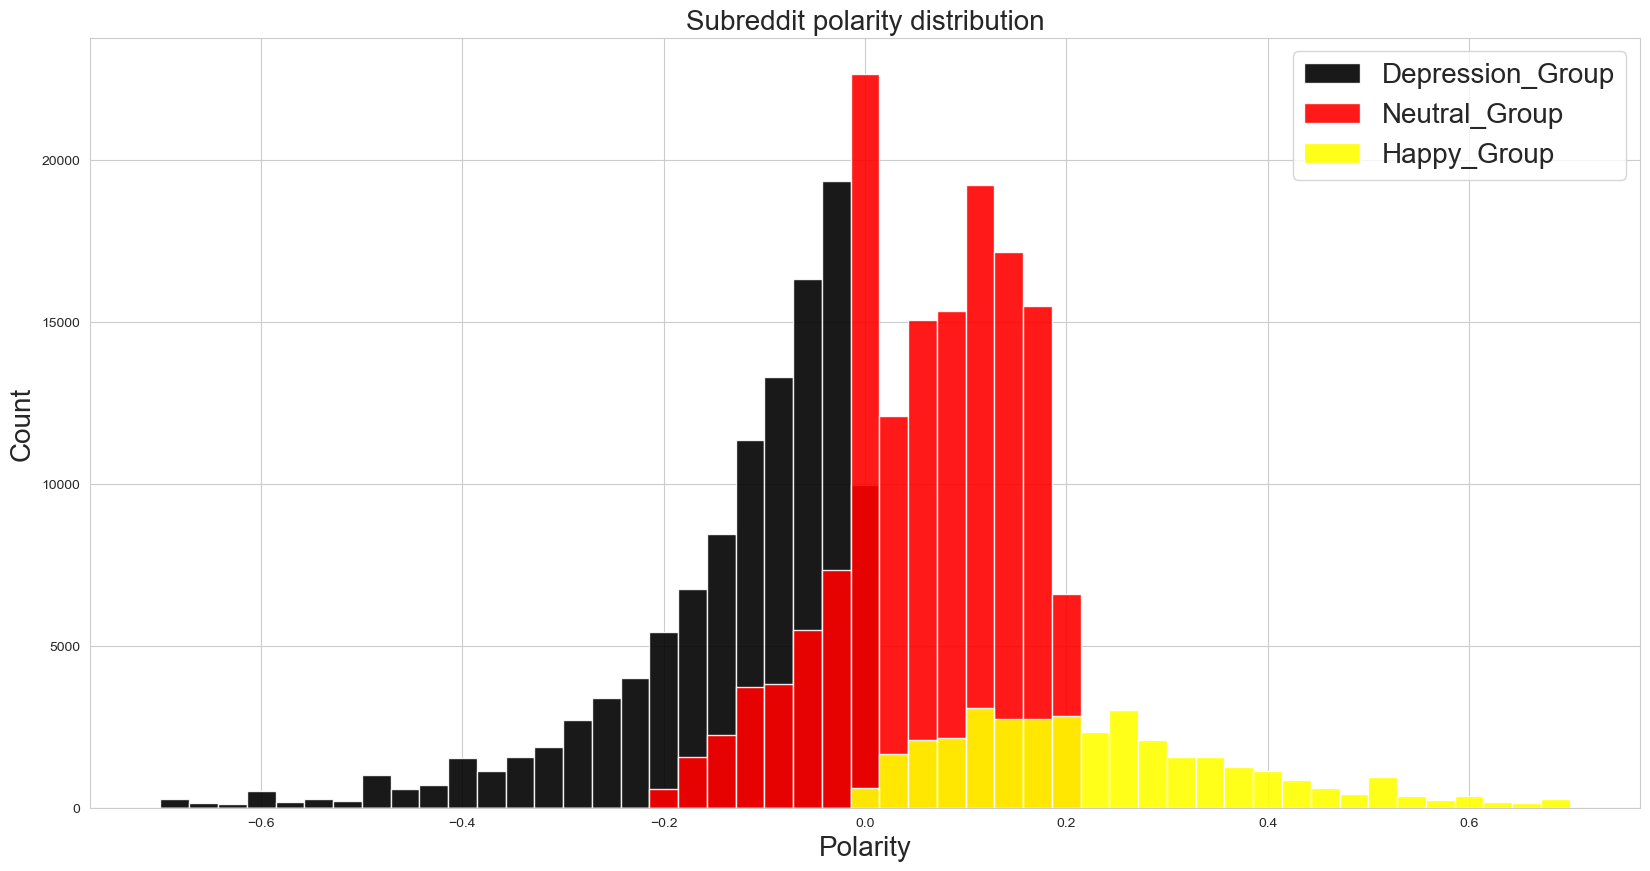

In [168]:
Depression_Group_df = Depression_Group_df[Depression_Group_df['polarity']< 0.0]
Neutral_Group_df =Neutral_Group_df.loc[(Neutral_Group_df['polarity'] > -0.2) & (Neutral_Group_df['polarity'] < 0.2)]
Happy_Group_df = Happy_Group_df[Happy_Group_df['polarity'] > 0.0]
print(f'Depression_Group_df lenghth is  : {len(Depression_Group_df)}')
print()
print(f'Neutral_Group_df lenghth is  : {len(Neutral_Group_df)}')
print()
print(f'Happy_Group_df lenghth is  : {len(Happy_Group_df)}')
print()

plt.figure(figsize=(20,10))
bins = np.linspace(-.7, .7, 50)

pyplot.hist(Depression_Group_df['polarity'], bins, alpha=0.9, label='Depression_Group',color='black')
pyplot.hist(Neutral_Group_df['polarity'], bins, alpha=0.9, label='Neutral_Group',color='red')
pyplot.hist(Happy_Group_df['polarity'], bins, alpha=0.9, label='Happy_Group',color='yellow')

plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
pyplot.legend(loc='upper right',fontsize=20)
plt.title('Subreddit polarity distribution',fontsize =20)

pyplot.show()

Depression_Group_df lenghth is  : 36820

Neutral_Group_df lenghth is  : 35583

Happy_Group_df lenghth is  : 36026



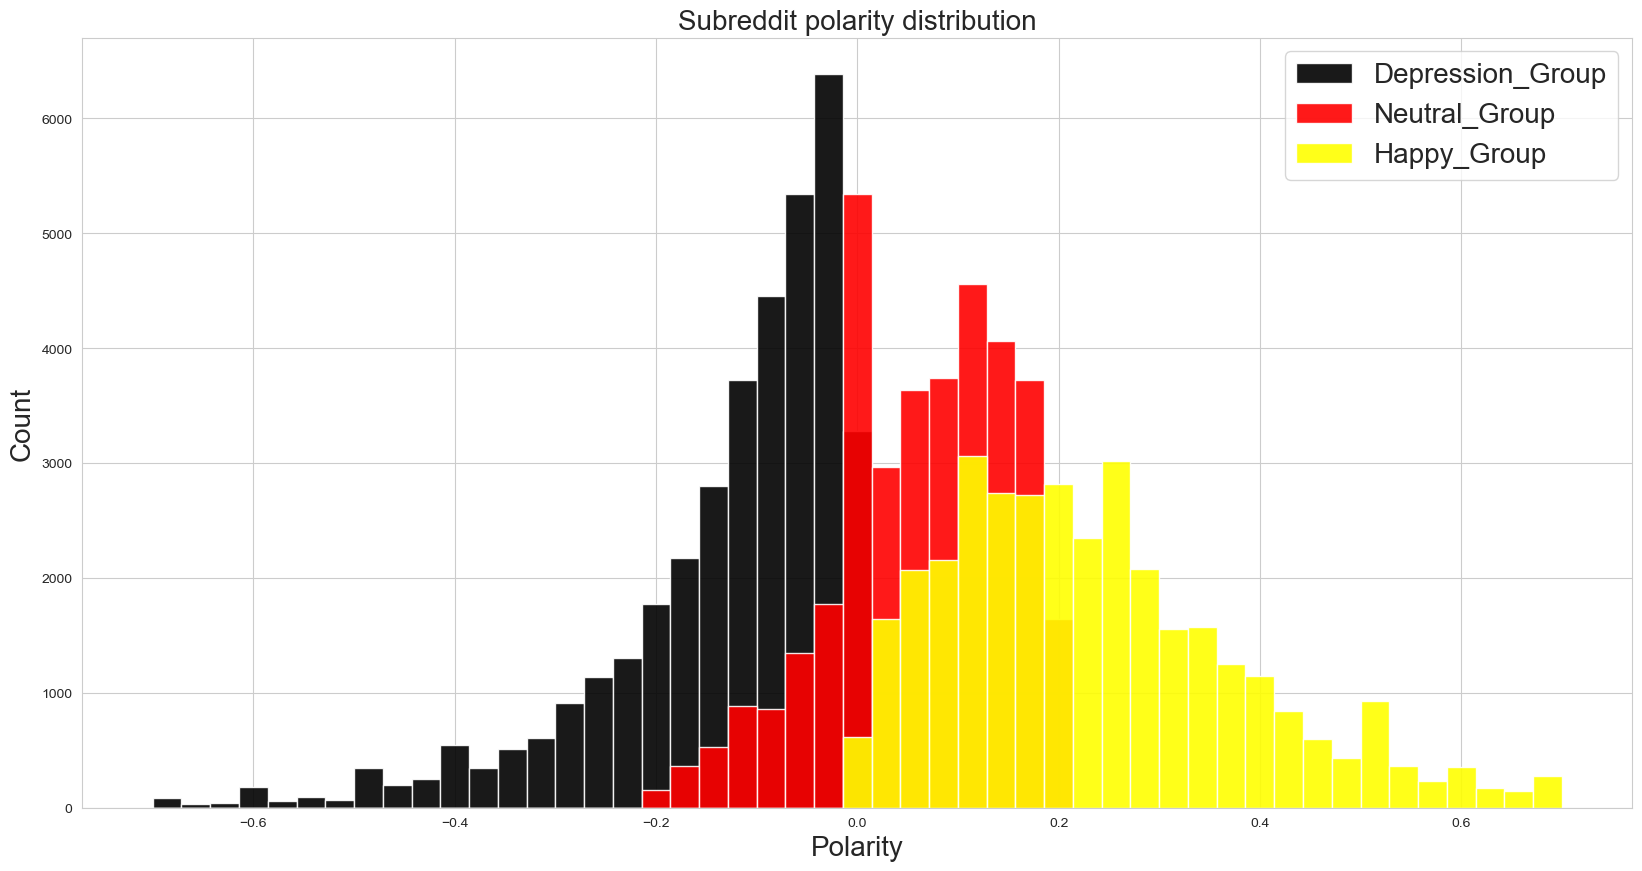

In [169]:
Depression_Group_df = Depression_Group_df.sample(frac=0.33, replace=True, random_state=1)
Neutral_Group_df = Neutral_Group_df.sample(frac=0.24, replace=True, random_state=1)
Happy_Group_df
print(f'Depression_Group_df lenghth is  : {len(Depression_Group_df)}')
print()
print(f'Neutral_Group_df lenghth is  : {len(Neutral_Group_df)}')
print()
print(f'Happy_Group_df lenghth is  : {len(Happy_Group_df)}')
print()

plt.figure(figsize=(20,10))
bins = np.linspace(-.7, .7, 50)

pyplot.hist(Depression_Group_df['polarity'], bins, alpha=0.9, label='Depression_Group',color='black')
pyplot.hist(Neutral_Group_df['polarity'], bins, alpha=0.9, label='Neutral_Group',color='red')
pyplot.hist(Happy_Group_df['polarity'], bins, alpha=0.9, label='Happy_Group',color='yellow')

plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
pyplot.legend(loc='upper right',fontsize=20)
plt.title('Subreddit polarity distribution',fontsize =20)

pyplot.show()

### Final pre-processsing step 

In [188]:
frames = [Depression_Group_df, Neutral_Group_df,Happy_Group_df]
final_whole_df = pd.concat(frames)

In [190]:
final_whole_df.head(5)

,subreddit,author,over_18,link_flair_text,title,selftext,url,created_utc,title_with_selftext,title_with_selftext_cleaned,polarity,class_group
256167,depression,ForksAreMyFriends,False,None,So this is weird,"I have a theory of having depression, I've bee...",https://www.reddit.com/r/depression/comments/4...,2016-04-20 21:04:44,So this is weird I have a theory of having dep...,weird theory depression feeling long time sel...,-0.051250,Depression_Group
188259,depression,DepressionIsNotReal,False,None,Need Advice,my daughter frequently tells me that she is de...,http://www.reddit.com/r/depression/comments/3d...,2015-07-19 07:00:17,Need Advice my daughter frequently tells me th...,need advice daughter frequently tell depressed...,-0.050000,Depression_Group
17134,AnxietyDepression,nanissomethingelse,False,NaN,Recently heavily cried at work,The reason I was crying is because I heard my ...,https://www.reddit.com/r/AnxietyDepression/com...,2021-12-11 15:20:50,Recently heavily cried at work The reason I wa...,recently heavily cried work reason cry heard b...,-0.060417,Depression_Group
254651,depression,Days2go,False,None,Something I want to get off my chest,"I'll be honest, it's not that I feel depressed...",https://www.reddit.com/r/depression/comments/4...,2016-04-15 03:39:44,Something I want to get off my chest I'll be h...,something want get chest honest feel depresse...,-0.178571,Depression_Group
117872,depression,werble8,False,None,Went off my meds. Went back on them. Freaking ...,I just went back on Venlafaxine XR (75mg) afte...,http://www.reddit.com/r/depression/comments/2d...,2014-08-08 21:40:33,Went off my meds. Went back on them. Freaking ...,went med went back freaking went back venla...,-0.130539,Depression_Group


In [173]:
### positive / negative extreme case experiment with polarity score

In [ ]:
## positive case

In [181]:
positive_10_extreme_example = final_whole_df[final_whole_df['polarity']==1.0]
positive_10_extreme_example['title_with_selftext'].tail(10).tolist()

['I had a wonderful, dream maybe a promotion 😊 I dreamed that i got a daughter, holding her in my arms. Feeling the warmth of a baby, feeling the way my dad felt.',
 'My best friend’s toddler said my name today It’s one of 12 words she can say and the only name other than Mama and Dada.',
 'I always forget my cake day but I just realized it’s on May 4th!!! This is awesome!!!!',
 "Someone once told me I wasn't meant for college, so I went and got a Bachelor of Science. Someone once told me that I wasn't meant for college and at best could go to a community college. I am graduating this fall with a Bachelor of Science in Information Science and Cybersecurity. ",
 "I'd like to take a moment to thank the reddit community Thank you reddit, for helping me in my toughest times. Thank you, those who gave me awards. Thank you, for giving me support throughout my depression. Thank you, reddit, you're the best.",
 'I’m marrying my best friend in 36 hours! Can’t wait!',
 'Who has a perfect relatio

In [182]:
positive_10_extreme_example['title_with_selftext_cleaned'].tail(10).tolist()

['wonderful  dream maybe promotion   dreamed got daughter  holding arm  feeling warmth baby  feeling way dad felt ',
 'best friend toddler said name today one word say name mama dada ',
 'always forget cake day realized may 4th    awesome    ',
 'someone told meant college  went got bachelor science  someone told meant college best could go community college  graduating fall bachelor science information science cybersecurity  ',
 'like take moment thank reddit community thank reddit  helping toughest time  thank  gave award  thank  giving support throughout depression  thank  reddit  best ',
 'marrying best friend hour  wait ',
 'perfect relationship   http   reddit com poll j7up2a ',
 'best day life like  ',
 'wich best  http   reddit com poll lanlwn ',
 'easter outfit turn  best could  amp  x200b http   preview redd s373o81kmjq61 jpg width amp format pjpg amp auto webp amp f3154a0c10b641f988788a1d2b00b67361ba0414']

In [ ]:
## negative case

In [176]:
negative_10_extreme_example = final_whole_df[final_whole_df['polarity']==-1.0]
negative_10_extreme_example['title_with_selftext'].tail(10).tolist()

['I feel horrible. I just need someome to talk to. I was told to post here from /r/selfharm.',
 'Thinking of putting this as my profile picture. Just to see if people notice. http://i.imgur.com/twSxjsT.jpg\r\rIs that pathetic.?',
 "I hit myself whenever I get upset Whenever I get upset or especially disappointed in myself, I'll hit my head until my ears ring and my hands hurt. I don't have the courage to cut or anything, but the pain is just something I feel like I deserve. ",
 'Anyone prescribed Buspar solely on an as needed basis for panic attacks? If so please give me your experience. I was just prescribed 5mg as needed if I’m having a panic attack but im terrified, I’ve only heard terrible things.',
 'Depression sucks and I would not wish it on my worst enemy Title',
 'Have you ever got to the point where you want people to tell you how horrible you are? Fire away. ',
 "Is there a song you listen to when you're feeling at your worst? Mine is **Avril 14th by Aphex Twin**. It's kinda

In [177]:
negative_10_extreme_example['title_with_selftext_cleaned'].tail(10).tolist()

['feel horrible  need someome talk  told post  r selfharm ',
 'thinking putting profile picture  see people notice  http   imgur com twsxjst jpg  pathetic  ',
 'hit whenever get upset whenever get upset especially disappointed  hit head ear ring hand hurt  courage cut anything  pain something feel like deserve  ',
 'anyone prescribed buspar solely needed basis panic attack  please give experience  prescribed 5mg needed panic attack im terrified  heard terrible thing ',
 'depression suck would wish worst enemy title',
 'ever got point want people tell horrible  fire away  ',
 'song listen feeling worst  mine   avril 14th aphex twin    kinda soundtrack depression  watched movie   probably recognise  ',
 'online chat hour  want talk someone phone  hearing someone voice nerve racking  tried looking online crappy tabletthat support flash phone computer  sitting 2am get  tried taking benadryl get sleep working  terrible thought scare  know ',
 'procrastination ruining spring break making com

In [ ]:
## download to csv 

In [183]:
final_whole_df.to_csv('final_preprocessed_df.csv')

In [ ]:
final_whole_df = pd.read_csv('final_preprocessed_df.csv')
final_whole_df.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [191]:
final_whole_df.head(5)

,subreddit,author,over_18,link_flair_text,title,selftext,url,created_utc,title_with_selftext,title_with_selftext_cleaned,polarity,class_group
256167,depression,ForksAreMyFriends,False,None,So this is weird,"I have a theory of having depression, I've bee...",https://www.reddit.com/r/depression/comments/4...,2016-04-20 21:04:44,So this is weird I have a theory of having dep...,weird theory depression feeling long time sel...,-0.051250,Depression_Group
188259,depression,DepressionIsNotReal,False,None,Need Advice,my daughter frequently tells me that she is de...,http://www.reddit.com/r/depression/comments/3d...,2015-07-19 07:00:17,Need Advice my daughter frequently tells me th...,need advice daughter frequently tell depressed...,-0.050000,Depression_Group
17134,AnxietyDepression,nanissomethingelse,False,NaN,Recently heavily cried at work,The reason I was crying is because I heard my ...,https://www.reddit.com/r/AnxietyDepression/com...,2021-12-11 15:20:50,Recently heavily cried at work The reason I wa...,recently heavily cried work reason cry heard b...,-0.060417,Depression_Group
254651,depression,Days2go,False,None,Something I want to get off my chest,"I'll be honest, it's not that I feel depressed...",https://www.reddit.com/r/depression/comments/4...,2016-04-15 03:39:44,Something I want to get off my chest I'll be h...,something want get chest honest feel depresse...,-0.178571,Depression_Group
117872,depression,werble8,False,None,Went off my meds. Went back on them. Freaking ...,I just went back on Venlafaxine XR (75mg) afte...,http://www.reddit.com/r/depression/comments/2d...,2014-08-08 21:40:33,Went off my meds. Went back on them. Freaking ...,went med went back freaking went back venla...,-0.130539,Depression_Group
